In [1]:
import os
import json
import math
import numpy as np
import xarray as xr
import geopandas as gpd

import cartopy.crs as ccrs

from multiprocessing import Pool

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down

## This code Compare the results of downscale using differents neighborhoods

In [2]:
# product, time_reso = 'PERSIANN', '1dy'
# product, time_reso = 'CMORPH', '3h'
product, time_reso = 'IMERG', '3h'
# product, time_reso = 'MSWEP', '3h'

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

if product == 'SM2RAIN':
    yy_s, yy_e = 2007, 2012
    year_vector = np.arange(yy_s, yy_e+1)
else:
    yy_s, yy_e = 2002, 2012
    year_vector = np.arange(yy_s, yy_e+1)

years_num = yy_e - yy_s + 1
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

NEIBHR = 2*param['npix']+1

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['BETA_cores']}')
print(f'Neighborhood area: {NEIBHR}x{NEIBHR}')
print()

Read json file   : IMERG_3h.json
Number of threads: 22
Neighborhood area: 5x5



In [5]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [6]:
print(f'Reading Data File : {param['file']}') 
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])

PRE_data = xr.open_dataset(dir_data)
PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN' or product == 'ERA5':
    PRE_data = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

if time_reso == '3h':
    PRE_data = PRE_data.resample(time ='D').sum(dim='time', skipna=False)

time_vector = PRE_data['time'].data

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data
lon2d, lat2d = np.meshgrid(lons, lats)

PRE_data

Reading Data File : IMERG_Italy_3h_2001_01_01_2023_12_31.nc


<xarray.Dataset> Size: 24MB
Dimensions:  (time: 4018, lat: 25, lon: 30)
Coordinates:
  * lat      (lat) float32 100B 44.55 44.65 44.75 44.85 ... 46.75 46.85 46.95
  * lon      (lon) float32 120B 10.55 10.65 10.75 10.85 ... 13.25 13.35 13.45
  * time     (time) datetime64[ns] 32kB 2002-01-01 2002-01-02 ... 2012-12-31
Data variables:
    PRE      (time, lat, lon) float64 24MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    description:  IMERG daily data for Italy region

## Yearly Weibull Parameters

In [7]:
num_processes = max(1, os.cpu_count() - 2)

def process_point(args):
    i, j, PRE_data, lats, lons = args
    TMP = ART_down.weibull_year_parameters(PRE_data, lats[i], lons[j], 1, 50)
    return i, j, TMP

# Crear lista de argumentos
args = [(i, j, PRE_data, lats, lons) for i in range(len(lats)) for j in range(len(lons))]

# Paralelizar cálculos
with Pool(processes=num_processes) as pool:
    results = pool.map(process_point, args)

# Recolectar resultados
N = np.zeros([years_num, len(lats), len(lons)])
C = np.zeros([years_num, len(lats), len(lons)])
W = np.zeros([years_num, len(lats), len(lons)])

for i, j, TMP in results:
    N[:, i, j] = TMP[:, 0]
    C[:, i, j] = TMP[:, 1]
    W[:, i, j] = TMP[:, 2]

## 5 Pixels - BETA and GAMMA

In [8]:
BETA_file = f'VENETO_BETA_{product}_{time_reso}_{yy_s}_{yy_e}_npix_5.nc'
dir_input = os.path.join(dir_base,'1_BETA',BETA_file)
print(f'Reading Beta File : {BETA_file}') 

DATA = xr.open_dataset(dir_input)

BETA5 = DATA['BETA'].values

del DATA

Reading Beta File : VENETO_BETA_IMERG_3h_2002_2012_npix_5.nc


In [9]:
GAMMA_file = f'VENETO_GAMMA_{product}_{time_reso}_{yy_s}_{yy_e}_npix_5.nc'
dir_input = os.path.join(dir_base,'2_GAMMA',GAMMA_file)
print(f'Reading Gamma File: {GAMMA_file}') 

DATA = xr.open_dataset(dir_input)

GAMMA5 = DATA['GAMMA'].values

del DATA

Reading Gamma File: VENETO_GAMMA_IMERG_3h_2002_2012_npix_5.nc


## 7 Pixels - BETA and GAMMA

In [10]:
BETA_file = f'VENETO_BETA_{product}_{time_reso}_{yy_s}_{yy_e}_npix_7.nc'
dir_input = os.path.join(dir_base,'1_BETA',BETA_file)
print(f'Reading Beta File : {BETA_file}') 

DATA = xr.open_dataset(dir_input)

BETA7 = DATA['BETA'].values

del DATA

Reading Beta File : VENETO_BETA_IMERG_3h_2002_2012_npix_7.nc


In [11]:
GAMMA_file = f'VENETO_GAMMA_{product}_{time_reso}_{yy_s}_{yy_e}_npix_7.nc'
dir_input = os.path.join(dir_base,'2_GAMMA',GAMMA_file)
print(f'Reading Gamma File: {GAMMA_file}') 

DATA = xr.open_dataset(dir_input)

GAMMA7 = DATA['GAMMA'].values

del DATA

Reading Gamma File: VENETO_GAMMA_IMERG_3h_2002_2012_npix_7.nc


## Verify difference

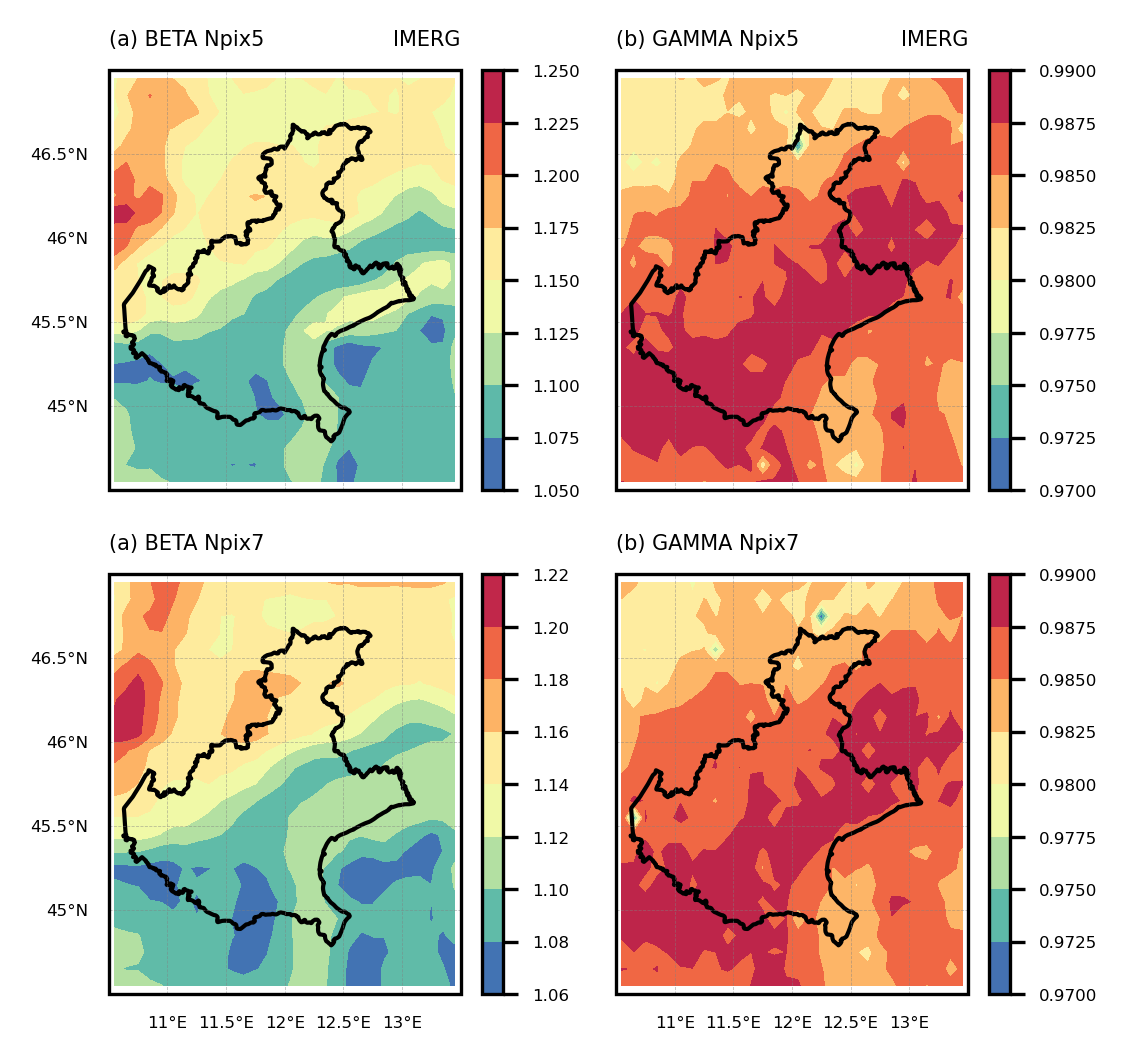

In [12]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(2,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, BETA5, cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) BETA Npix5', fontsize=5, loc='left')
ax1.set_title(f'{product}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, GAMMA5, cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) GAMMA Npix5', fontsize=5, loc='left')
ax1.set_title(f'{product}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, BETA7, cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) BETA Npix7', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, GAMMA7, cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) GAMMA Npix7', fontsize=5, loc='left')

# ==============================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)

## Downscale Parameters

In [13]:
Nd5, Cd5, Wd5 = ART_down.down_year_parameters(N, C, W, BETA5, GAMMA5)
Nd7, Cd7, Wd7 = ART_down.down_year_parameters(N, C, W, BETA7, GAMMA7)

Text(0.0, 1.0, '(c) Mean Wd7')

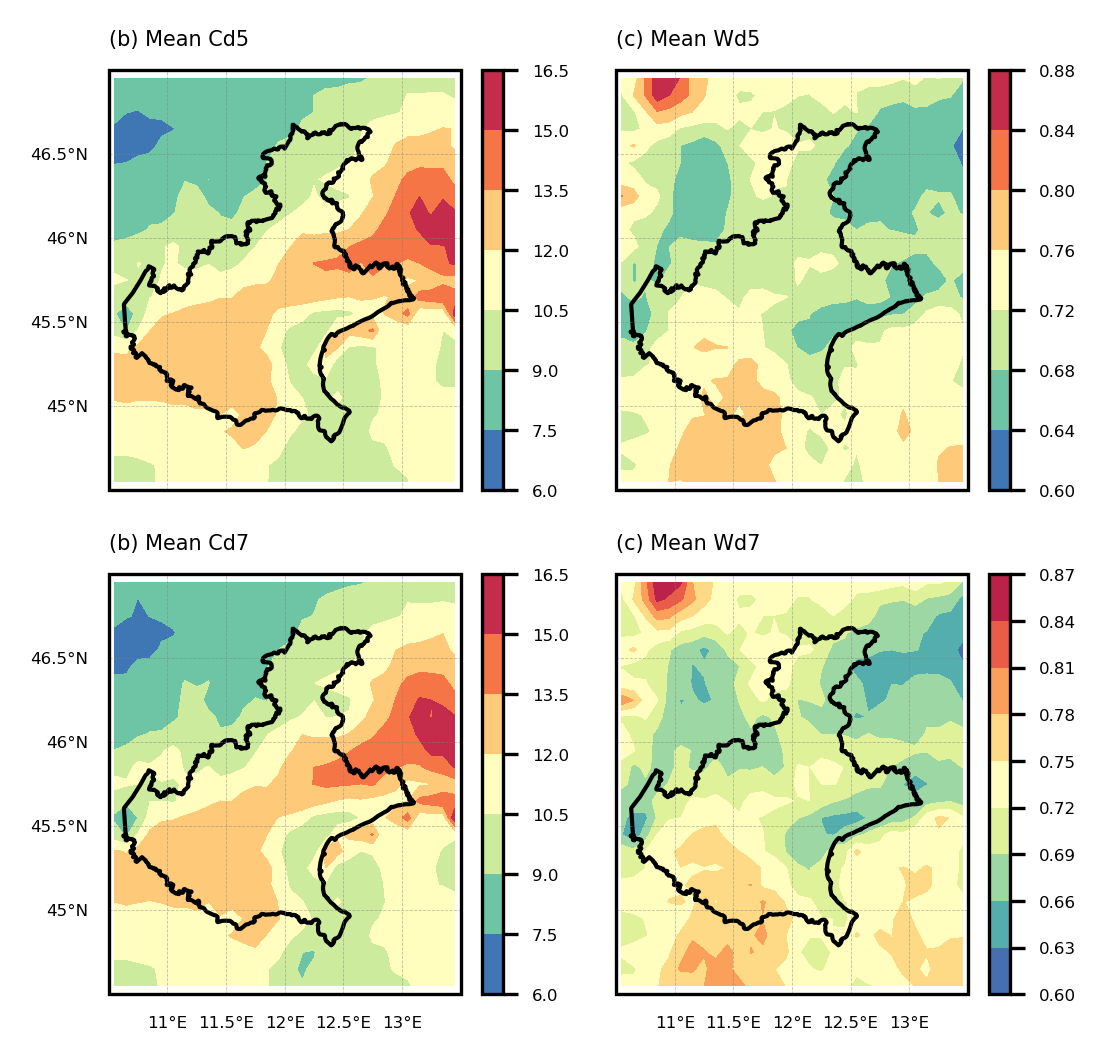

In [14]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,4),dpi=300)
gs = gridspec.GridSpec(2,2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, np.mean(Cd5,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Mean Cd5', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, np.mean(Wd5,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Mean Wd5', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, np.mean(Cd7,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = True
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Mean Cd7', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, np.mean(Wd7,axis=0), cmap=cmap)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Mean Wd7', fontsize=5, loc='left')

# ==============================================================================


In [15]:
Tr = [10, 20, 50, 100]
QUANTILE5 = ART_down.pre_quantiles_array(Nd5, Cd5, Wd5, Tr, lats, lons, 1)
QUANTILE7 = ART_down.pre_quantiles_array(Nd7, Cd7, Wd7, Tr, lats, lons, 1)

In [16]:
if product == 'SM2RAIN':
    QUANTILE5 = xr.where(QUANTILE5 < 0, 0, QUANTILE5)
    QUANTILE7 = xr.where(QUANTILE7 < 0, 0, QUANTILE7)

Text(0.0, 1.0, '(c) Tr = 50 years')

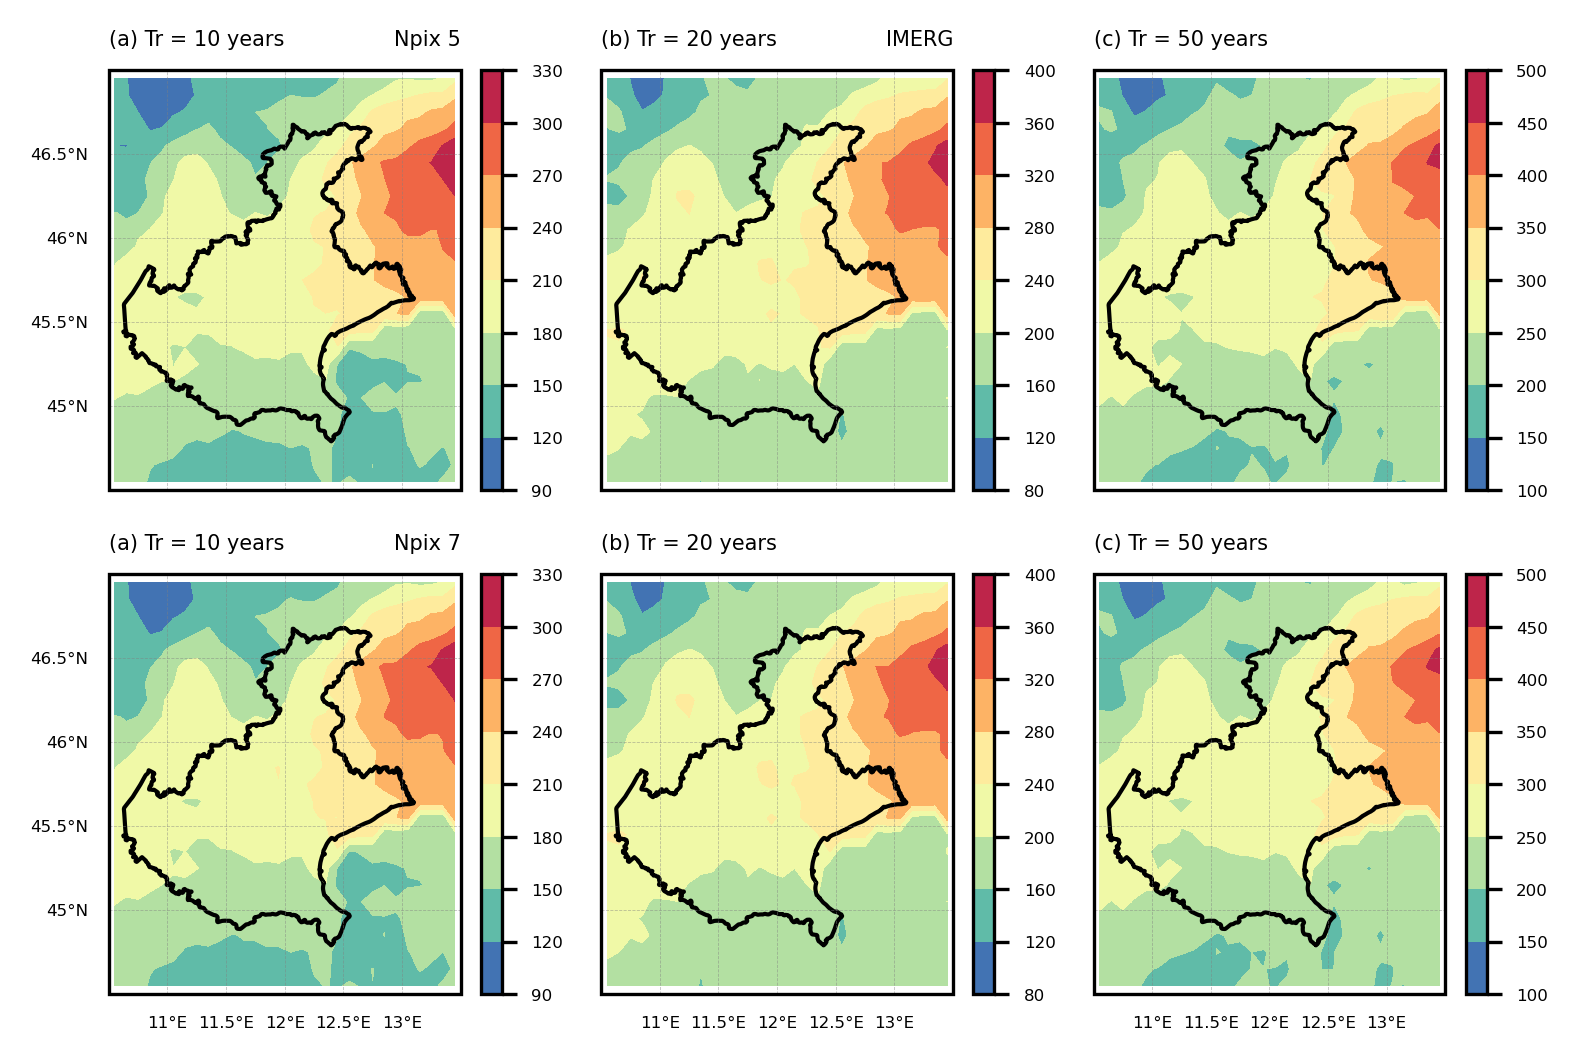

In [17]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,4),dpi=300)
gs = gridspec.GridSpec(2,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, QUANTILE5[0,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Tr = {Tr[0]} years', fontsize=5, loc='left')
ax1.set_title(f'Npix 5', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, QUANTILE5[1,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Tr = {Tr[1]} years', fontsize=5, loc='left')
ax1.set_title(f'{product}', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, QUANTILE5[2,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = False
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Tr = {Tr[2]} years', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, QUANTILE7[0,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(a) Tr = {Tr[0]} years', fontsize=5, loc='left')
ax1.set_title(f'Npix 7', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, QUANTILE7[1,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(b) Tr = {Tr[1]} years', fontsize=5, loc='left')

# ==============================================================================
ax1 = plt.subplot(gs[1, 2], projection = proj)
ax1.set_extent([lon_min, lon_max, lat_min, lat_max],crs=proj)
a1 = ax1.contourf(lon2d, lat2d, QUANTILE7[2,:,:], cmap=cmap, transform=proj)
VENETO.plot(facecolor='None', ax=ax1)

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.left_labels = False
gl.xlabel_style = {'size': 4, 'color': 'k'}
gl.ylabel_style = {'size': 4, 'color': 'k'}

cbar = plt.colorbar(a1, fraction=0.053)
cbar.ax.tick_params(labelsize=4)

ax1.set_title(f'(c) Tr = {Tr[2]} years', fontsize=5, loc='left')


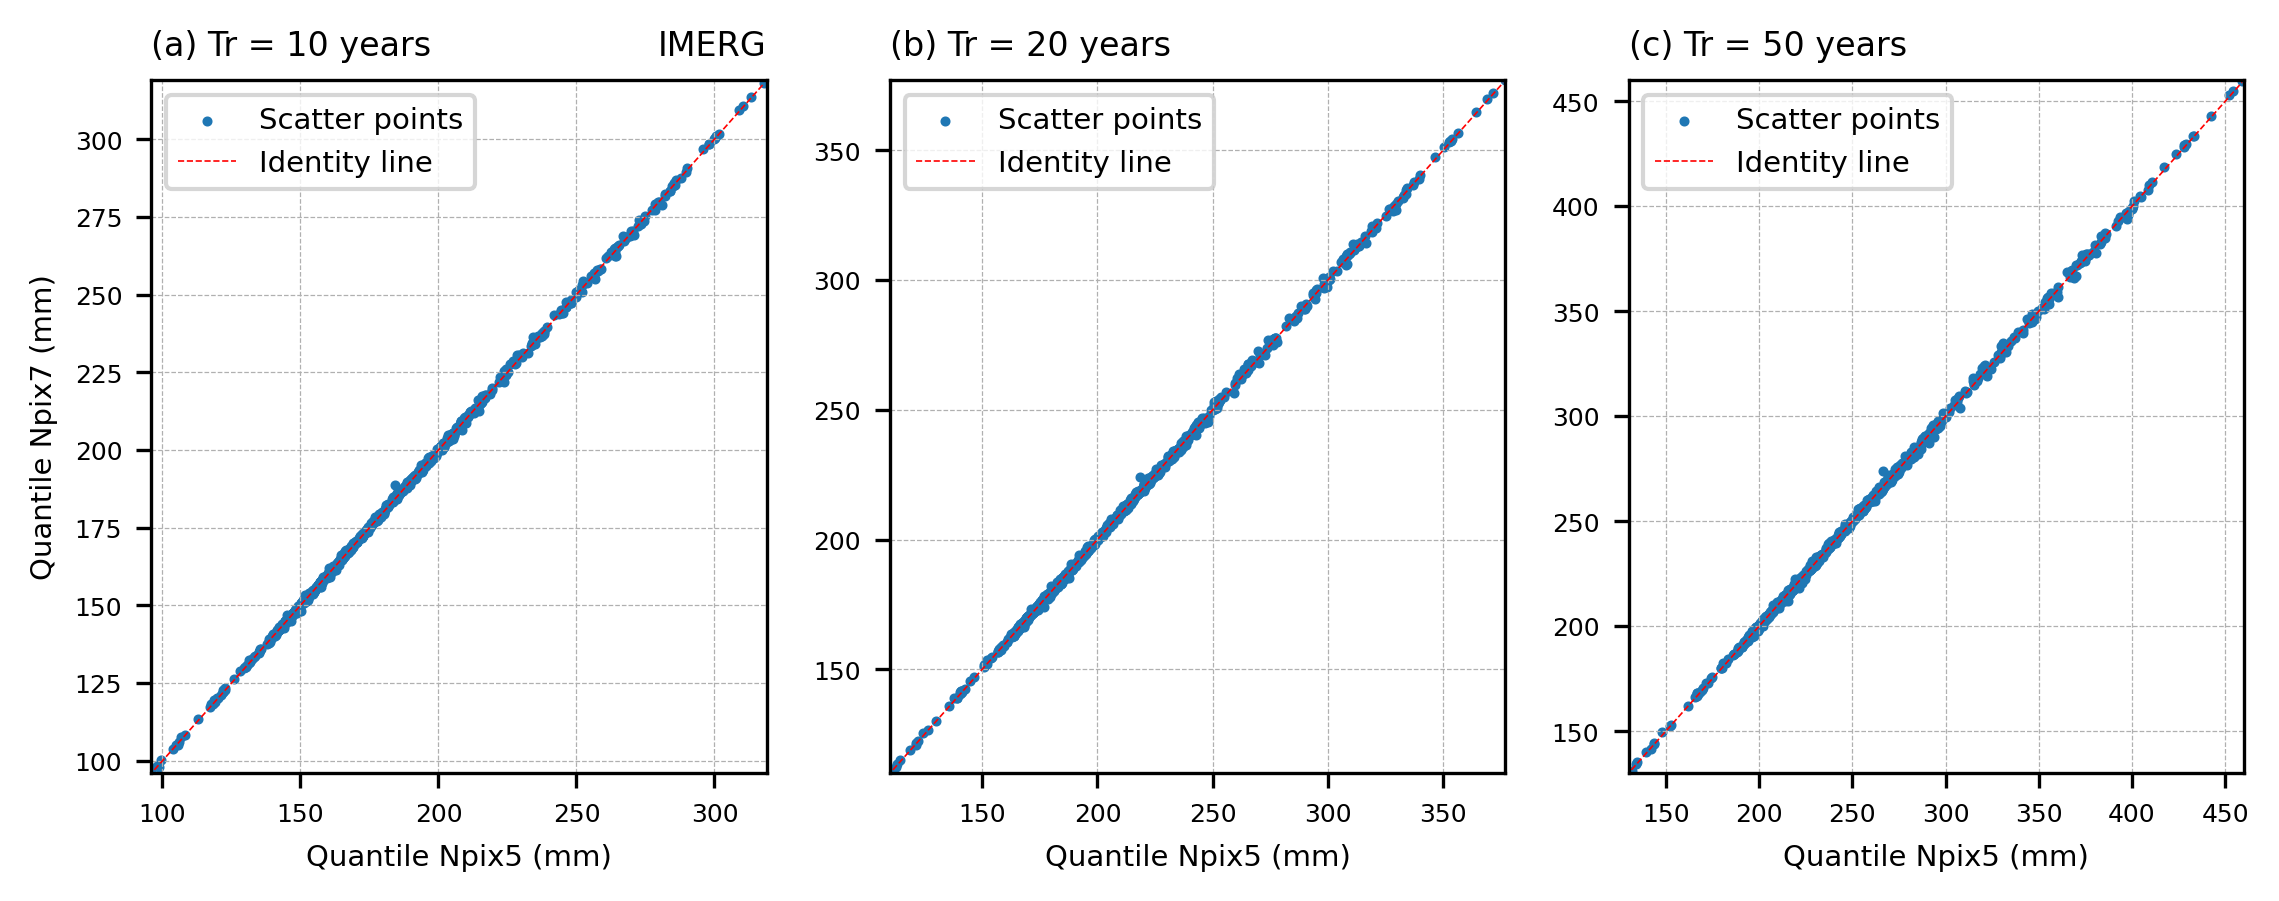

In [18]:
fig = plt.figure(figsize=(9,3),dpi=300)
gs = gridspec.GridSpec(1,3)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0])
max_val = np.max([
                np.nanmax(QUANTILE5[0,:,:].flatten()),
                np.nanmax(QUANTILE7[0,:,:].flatten())])
min_val = np.min([
                np.nanmin(QUANTILE5[0,:,:].flatten()),
                np.nanmin(QUANTILE7[0,:,:].flatten())])
xx = np.arange(max_val)
ax1.scatter(QUANTILE5[0,:,:].flatten(), QUANTILE7[0,:,:].flatten(), s=2, label='Scatter points')
ax1.plot(xx,xx,color='r',linewidth=0.4,linestyle='--', label='Identity line')
ax1.set_xlim(math.ceil(min_val), math.ceil(max_val))
ax1.set_ylim(math.ceil(min_val), math.ceil(max_val))
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_title(f'(a) Tr = {Tr[0]} years', fontsize=8, loc='left')
ax1.set_title(f'{product}', fontsize=8, loc='right')
ax1.set_xlabel('Quantile Npix5 (mm)', fontsize=7)
ax1.set_ylabel('Quantile Npix7 (mm)', fontsize=7)
ax1.legend(fontsize=7, loc=2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 1])
max_val = np.max([
                np.nanmax(QUANTILE5[1,:,:].flatten()),
                np.nanmax(QUANTILE7[1,:,:].flatten())])
min_val = np.min([
                np.nanmin(QUANTILE5[1,:,:].flatten()),
                np.nanmin(QUANTILE7[1,:,:].flatten())])
xx = np.arange(max_val)
ax1.scatter(QUANTILE5[1,:,:].flatten(), QUANTILE7[1,:,:].flatten(), s=2, label='Scatter points')
ax1.plot(xx,xx,color='r',linewidth=0.4,linestyle='--', label='Identity line')
ax1.set_xlim(math.ceil(min_val), math.ceil(max_val))
ax1.set_ylim(math.ceil(min_val), math.ceil(max_val))
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_title(f'(b) Tr = {Tr[1]} years', fontsize=8, loc='left')
ax1.set_xlabel('Quantile Npix5 (mm)', fontsize=7)
ax1.legend(fontsize=7, loc=2)

# ==============================================================================
ax1 = plt.subplot(gs[0, 2])
max_val = np.max([
                np.nanmax(QUANTILE5[2,:,:].flatten()),
                np.nanmax(QUANTILE7[2,:,:].flatten())])
min_val = np.min([
                np.nanmin(QUANTILE5[2,:,:].flatten()),
                np.nanmin(QUANTILE7[2,:,:].flatten())])
xx = np.arange(max_val)
ax1.scatter(QUANTILE5[2,:,:].flatten(), QUANTILE7[2,:,:].flatten(), s=2, label='Scatter points')
ax1.plot(xx,xx,color='r',linewidth=0.4,linestyle='--', label='Identity line')
ax1.set_xlim(math.ceil(min_val), math.ceil(max_val))
ax1.set_ylim(math.ceil(min_val), math.ceil(max_val))
ax1.grid(linewidth=0.3, linestyle='--')
ax1.tick_params(axis='both', which='major', labelsize=6)
ax1.set_title(f'(c) Tr = {Tr[2]} years', fontsize=8, loc='left')
ax1.set_xlabel('Quantile Npix5 (mm)', fontsize=7)
ax1.legend(fontsize=7, loc=2)

# ==============================================================================
ax1.set_facecolor('white')
fig.patch.set_alpha(0)